### Import necessary libraries

In [1]:
import cv2
import skimage
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from skimage.segmentation import slic
from skimage.util import img_as_float
from scipy import ndimage as nd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from keras.backend import tf
import concurrent.futures
from skimage.metrics import structural_similarity as ssim
import time
import sys

### Feature Extraction Functions

In [2]:
# This function extracts features based on gaussian (sigma = 3 and sigma = 7) and
# variance (size = 3)
def extract_all(img):

    img2 = img.reshape(-1)
    
    # First feature is grayvalue of pixel
    df = pd.DataFrame()
    df['GrayValue(I)'] = img2 

    # Second feature is GAUSSIAN filter with sigma=3
    gaussian_img = nd.gaussian_filter(img, sigma=3)
    gaussian_img1 = gaussian_img.reshape(-1)
    df['Gaussian s3'] = gaussian_img1

    # Third feature is GAUSSIAN fiter with sigma=7
    gaussian_img2 = nd.gaussian_filter(img, sigma=7)
    gaussian_img3 = gaussian_img2.reshape(-1)
    df['Gaussian s7'] = gaussian_img3    

    # Third feature is generic filter that variance of pixel with size=3
    variance_img = nd.generic_filter(img, np.var, size=3)
    variance_img1 = variance_img.reshape(-1)
    df['Variance s3'] = variance_img1
    
    return df

In [3]:
# This function extracts average pixel value of some neighbors
# frame size : (distance * 2) + 1 x (distance * 2) + 1
#default value of distance is 8 if the function is called without second parameter
def extract_neighbors_features(img,distance = 8):

    height,width = img.shape
    X = []

    for x in range(height):
        for y in range(width):
            neighbors = []
            for k in range(x-distance, x+distance +1 ):
                for p in range(y-distance, y+distance +1 ):
                    if x == k and p == y:
                        continue
                    elif ((k>0 and p>0 ) and (k<height and p<width)):
                        neighbors.append(img[k][p])
                    else:
                        neighbors.append(0)

            X.append(sum(neighbors) / len(neighbors))

    return X

In [4]:
# This function extracts superpixels
# Every cell has a value in superpixel frame so 
# It is extracting superpixel value of every pixel
def superpixel(image,status):    
    if status:
        segments = slic(img_as_float(image), n_segments = 100, sigma = 5, channel_axis=None)
    else:
        segments = slic(img_as_float(image), n_segments = 100, sigma = 5,compactness=.1, channel_axis=None) 

    return segments

### MAE Function

In [5]:
# Function to calculate Mean Absolute Error
def calculate_mae(y_true,y_predict):
    
    # Calculate mean absolute error for every color according to MAE formula
    error_b = float(sum([abs(float(item_true) - float(item_predict)) for item_true, item_predict in zip(y_true[:,0], y_predict[:,0])]) / len(y_true))
    error_g = float(sum([abs(float(item_true) - float(item_predict)) for item_true, item_predict in zip(y_true[:,1], y_predict[:,1])]) / len(y_true))
    error_r = float(sum([abs(float(item_true) - float(item_predict)) for item_true, item_predict in zip(y_true[:,2], y_predict[:,2])]) / len(y_true))
    
    # Return aveage of colours error
    return (((error_b + error_g + error_r) / 3))
# Fuction to calculate Mean Squared Error
def calculate_mse(y_true,y_predict):
        
    # Calculate mean squared error for every color according to MSE formula
    error_b = float(sum([(float(item_true) - float(item_predict))**2 for item_true, item_predict in zip(y_true[:,0], y_predict[:,0])]) / len(y_true))
    error_g = float(sum([(float(item_true) - float(item_predict))**2 for item_true, item_predict in zip(y_true[:,1], y_predict[:,1])]) / len(y_true))
    error_r = float(sum([(float(item_true) - float(item_predict))**2 for item_true, item_predict in zip(y_true[:,2], y_predict[:,2])]) / len(y_true))
        
     # Return aveage of colours error
    return (((error_b + error_g + error_r) / 3))

In [6]:
# Function to save predicted images in Outputs folder in Dataset folder
def save_picture(test_data,rgb_data_name,y_predict):
    
    # If Outputs folder is not exist in directory of Dataset create it
    if not os.path.exists('E:/TER/KNN DataSet/Outputs'):
        os.makedirs('E:/TER/KNN DataSet/Outputs')
    
    # Create an array for colorful image 
    height,width = test_data.shape
    data = np.zeros((height, width, 3), dtype=np.uint8)

    # Fill the data with predicted RGB values
    tmp = 0
    for i in range(height):
        for k in range(width):
            data[i,k] = [y_predict[tmp][0], y_predict[tmp][1], y_predict[tmp][2]]
            tmp +=1
            
    # Save predicted image
    cv2.imwrite('E:/TER/KNN DataSet/Outputs/' + rgb_data_name + '.jpg', data)
    return data 

### Setting constant variables

In [7]:
distance = 1
minImageIndex  = 1
maxImageIndex  = 27

### Read all images in Dataset and create input for model from images

In [8]:
# Read Images from Dataset folder

# rgb_data using for source colorful images
rgb_data = [cv2.imread(file, 1) for file in glob.glob('E:/TER/KNN DataSet/images/*source.*')]

# rgb_data_names is using for image names
rgb_data_names = [file.split(',')[0].split('\\')[1] for file in glob.glob("E:/TER/KNN DataSet/images/*source.*")][minImageIndex-1:maxImageIndex]

# train_data is grayscale of colorful source images
train_data = [cv2.imread(file, 0) for file in glob.glob('E:/TER/KNN DataSet/images/*source.*')][minImageIndex-1:maxImageIndex]

# test_data is using for grayscale type of target images
test_data = [cv2.imread(file, 0) for file in glob.glob('E:/TER/KNN DataSet/images/*target.*')][minImageIndex-1:maxImageIndex]

# accuracy_data is using for colorful groundtruth images
accuracy_data = [cv2.imread(file, 1) for file in glob.glob('E:/TER/KNN DataSet/images/*groundtruth.*')][minImageIndex-1:maxImageIndex]


predicted_picture = []

Mean Squared Error for p001 is 858.5727963821977 RAM take: 4.57763671875e-05MB time take: 1147.6088387966156for(2880, 5120)


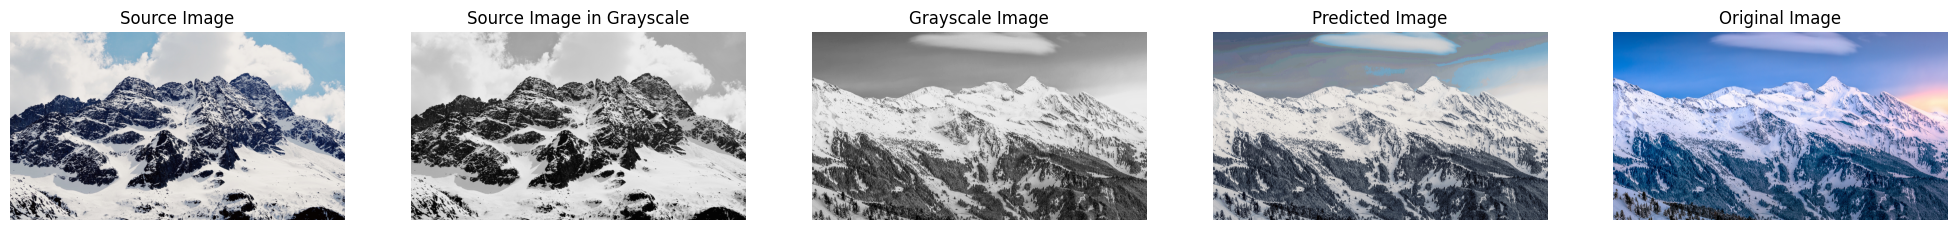

Mean Squared Error for p002 is 448.78802829318573 RAM take: 4.57763671875e-05MB time take: 41.72604775428772for(768, 1024)


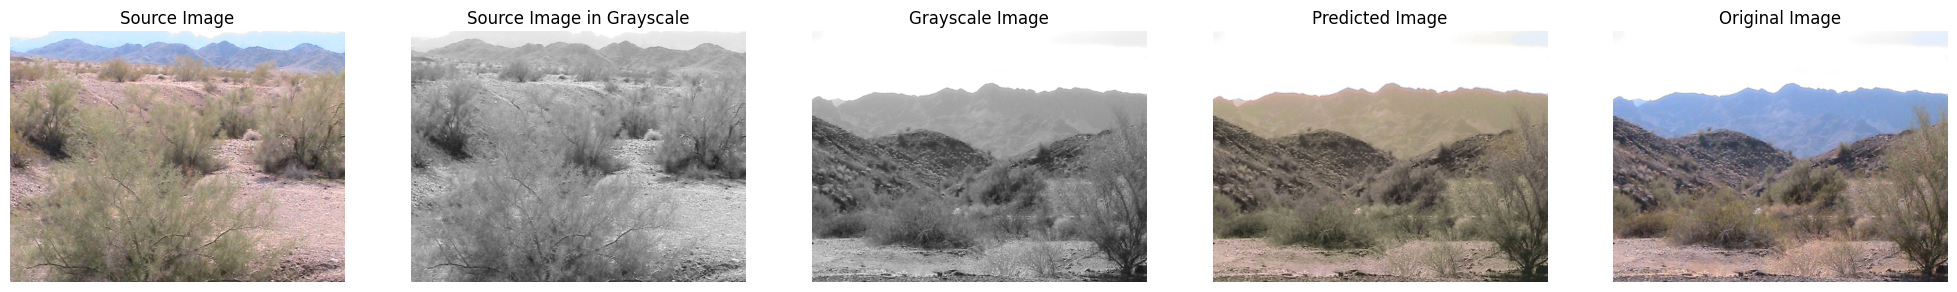

Mean Squared Error for p003 is 891.2897598958334 RAM take: 4.57763671875e-05MB time take: 35.774556398391724for(800, 800)


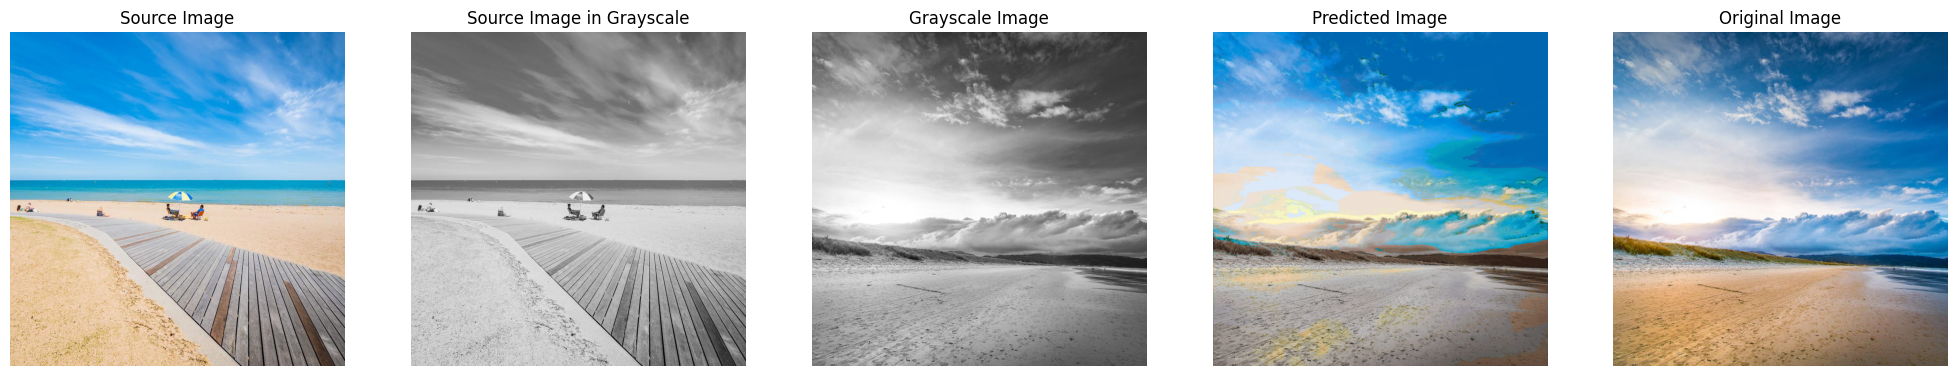

In [9]:
for i in range(len(rgb_data)):   
    start_time = time.time()

    # preparing y (b, g, r)
    y = rgb_data[i].reshape((-1,3))
    
    # preparing y_true (b, g, r)
    y_true = accuracy_data[i].reshape((-1,3))       
    
    # preparing X variable
    X1 = extract_all(train_data[i]).values
    X2 = superpixel(train_data[i],False).reshape(-1,1)
    X3 = extract_neighbors_features(train_data[i],distance)
    X = np.c_[X1, X2, X3]    
    # Now we have input for training the model 
    # We have total 6 feature in X which are
    #Colums: GrayValue, Gaussians3, Gaussians7, GenericFilter(variance)s3, superpixel, averageOfFrameGrayValues    
    
    
    # preparing X_test variable
    X1_test = extract_all(test_data[i]).values
    X2_test = superpixel(test_data[i],False).reshape(-1,1)
    X3_test = extract_neighbors_features(test_data[i],distance)
    X_test = np.c_[X1_test, X2_test, X3_test]
    # Now we have input X_test values too for predict RGB values from it
    
    # training model
    knn_clf = KNeighborsClassifier()
    knn_clf.fit(X,y)
    
    # testing model
    y_predict = knn_clf.predict(X_test)

    # Save Picture to Dataset/Outputs folder
    predicted_picture.append(save_picture(test_data[i],rgb_data_names[i],y_predict))
    
    # Plot Original and predicted images
    fig, ax = plt.subplots(1, 5 , figsize=(25,5))
    ax[4].imshow(cv2.cvtColor(accuracy_data[i], cv2.COLOR_BGR2RGB))
    ax[4].set_title("Original Image")
    ax[4].axis('off')

    ax[3].imshow(cv2.cvtColor(predicted_picture[i], cv2.COLOR_BGR2RGB))
    ax[3].set_title("Predicted Image")
    ax[3].axis('off')

    ax[2].imshow(test_data[i], cmap='gray')
    ax[2].set_title("Grayscale Image")
    ax[2].axis('off')

    ax[1].imshow(cv2.cvtColor(train_data[i], cv2.COLOR_BGR2RGB), cmap='gray')
    ax[1].set_title("Source Image in Grayscale")
    ax[1].axis('off')
    ax[0].imshow(cv2.cvtColor(rgb_data[i], cv2.COLOR_BGR2RGB))
    ax[0].set_title("Source Image")
    ax[0].axis('off')

    print("Mean Squared Error for " + rgb_data_names[i] + " is " + str(calculate_mse(y_true,y_predict)) +" RAM take: " + str(sys.getsizeof(knn_clf)/1024/1024) + "MB time take: " + str(time.time() - start_time) + ' for ' + str(np.shape(test_data[i])))
    plt.show()

In [ ]:
# Print average of mean absolute error to secreen
#print("Average of MAE is: ",sum(MAE) / maxImageIndex)

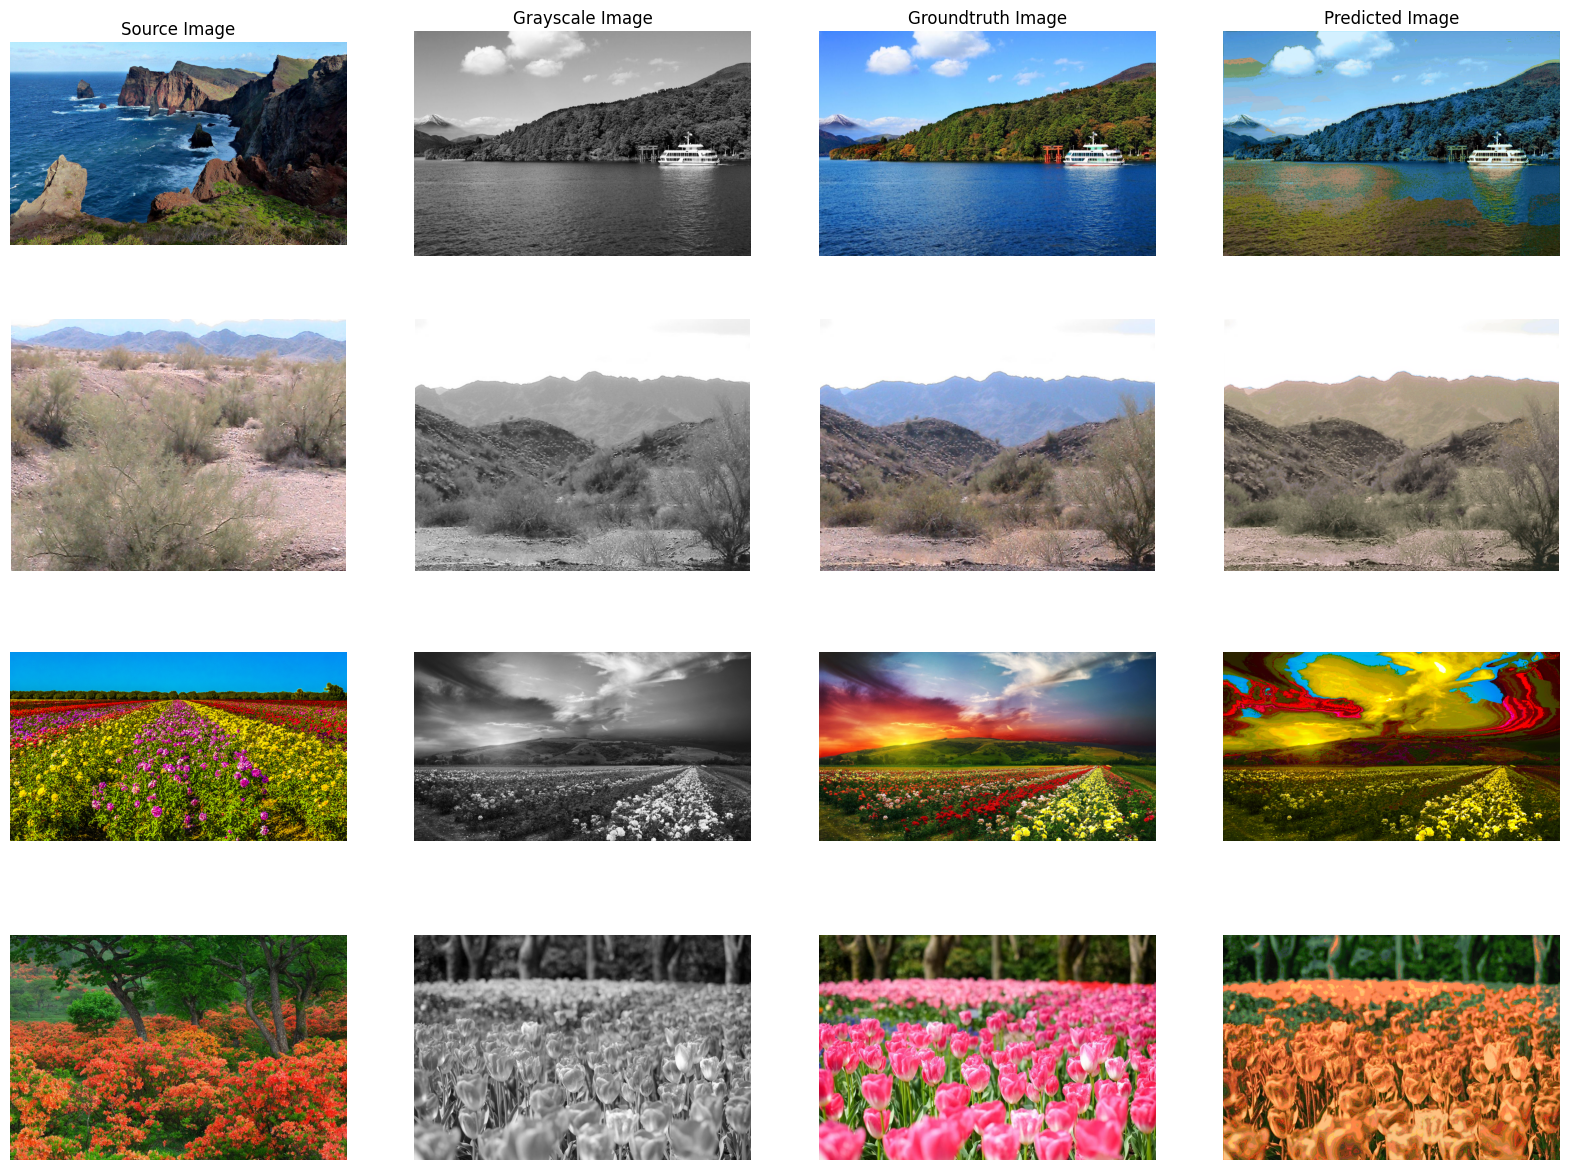

In [ ]:
n=[12, 2, 23, 25]
plt.close('all')
plt.figure(figsize=(20,15))
plt.subplot(4,4,1)
plt.title("Source Image")
plt.subplot(4,4,2)
plt.title("Grayscale Image")
plt.subplot(4,4,3)
plt.title("Groundtruth Image")
plt.subplot(4,4,4)
plt.title("Predicted Image")
for i in range(len(n)):
    plt.subplot(4,4,4*i+1)
    plt.imshow(cv2.cvtColor(rgb_data[n[i]-1], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.subplot(4,4,4*i+2)
    plt.imshow(cv2.cvtColor(test_data[n[i]-1], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.subplot(4,4,4*i+3)
    plt.imshow(cv2.cvtColor(accuracy_data[n[i]-1], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.subplot(4,4,4*i+4)
    plt.imshow(cv2.cvtColor(predicted_picture[n[i]-1], cv2.COLOR_BGR2RGB))
    plt.axis('off')

In [ ]:
#计算SSIM并输出
for i in range(len(rgb_data)):
    ssim_s = ssim(accuracy_data[i], predicted_picture[i], multichannel=True, channel_axis=2)
    print(str(rgb_data_names[i])+" SSIM is: "+str(ssim_s))
# Write average of mean absolute error to file
#f.write(str(sum(MAE) / maxImageIndex))

# Close the file
#f.close()

p001 SSIM is: 0.7843451648138955
p002 SSIM is: 0.9184915136006707
p003 SSIM is: 0.7640007588518768
p004 SSIM is: 0.8623723456365385
p005 SSIM is: 0.8874124273244801
p006 SSIM is: 0.8025132142052133
p007 SSIM is: 0.7495561907898177
p008 SSIM is: 0.8493895865703472
p009 SSIM is: 0.8664451886467207
p010 SSIM is: 0.9050453017263179
p011 SSIM is: 0.7818832984771994
p012 SSIM is: 0.6805203441817823
p013 SSIM is: 0.5406258293123078
p014 SSIM is: 0.9205282037541972
p015 SSIM is: 0.8254349018279118
p016 SSIM is: 0.7946563806803173
p017 SSIM is: 0.8373852570775967
p018 SSIM is: 0.6837527298124066
p019 SSIM is: 0.7202890015547201
p020 SSIM is: 0.5978531180491632
p021 SSIM is: 0.8333148476476823
p022 SSIM is: 0.7823987743676611
p023 SSIM is: 0.4261593528685758
p024 SSIM is: 0.8647483650485585
p025 SSIM is: 0.5204057931325174
p026 SSIM is: 0.8044947164314348
p027 SSIM is: 0.7493138702124869
